In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [0]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter


Load the data

Here you'll use torchvision to load the data (documentation). The data should be included alongside this notebook, otherwise you can download it here. The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [0]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
vloader = torch.utils.data.DataLoader(validation_data, batch_size =32,shuffle = True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:

structures = {"vgg16":25088,
              "densenet121" : 1024,
              "alexnet" : 9216 }

In [10]:
def nn_setup(structure='vgg16',dropout=0.5, hidden_layer1 = 120,lr = 0.001):
    
    
    if structure == 'vgg16':
        model = models.vgg16(pretrained=True)        
    elif structure == 'densenet121':
        model = models.densenet121(pretrained=True)
    elif structure == 'alexnet':
        model = models.alexnet(pretrained = True)
    else:
        print("Im sorry but {} is not a valid model.Did you mean vgg16,densenet121,or alexnet?".format(structure))
        
    
        
    for param in model.parameters():
        param.requires_grad = False

        from collections import OrderedDict
        classifier = nn.Sequential(OrderedDict([
            ('dropout',nn.Dropout(dropout)),
            ('inputs', nn.Linear(structures[structure], hidden_layer1)),
            ('relu1', nn.ReLU()),
            ('hidden_layer1', nn.Linear(hidden_layer1, 90)),
            ('relu2',nn.ReLU()),
            ('hidden_layer2',nn.Linear(90,80)),
            ('relu3',nn.ReLU()),
            ('hidden_layer3',nn.Linear(80,102)),
            ('output', nn.LogSoftmax(dim=1))
                          ]))
        
        
        model.classifier = classifier
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.classifier.parameters(), lr )
        model.cuda()
        
        return model , optimizer ,criterion 

    

model,optimizer,criterion = nn_setup('densenet121')

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [11]:
# Putting the above into functions, so they can be used later

epochs = 12
print_every = 5
steps = 0
loss_show=[]

# change to cuda
model.to('cuda')

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs,labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            vlost = 0
            accuracy=0
            
            
            for ii, (inputs2,labels2) in enumerate(vloader):
                optimizer.zero_grad()
                
                inputs2, labels2 = inputs2.to('cuda:0') , labels2.to('cuda:0')
                model.to('cuda:0')
                with torch.no_grad():    
                    outputs = model.forward(inputs2)
                    vlost = criterion(outputs,labels2)
                    ps = torch.exp(outputs).data
                    equality = (labels2.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            vlost = vlost / len(vloader)
            accuracy = accuracy /len(vloader)
            
                    
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Lost {:.4f}".format(vlost),
                   "Accuracy: {:.4f}".format(accuracy))
            
            
            running_loss = 0


Epoch: 1/12...  Loss: 4.6229 Validation Lost 0.1783 Accuracy: 0.0192
Epoch: 1/12...  Loss: 4.6238 Validation Lost 0.1776 Accuracy: 0.0228
Epoch: 1/12...  Loss: 4.5819 Validation Lost 0.1738 Accuracy: 0.0325
Epoch: 1/12...  Loss: 4.5633 Validation Lost 0.1709 Accuracy: 0.0262
Epoch: 1/12...  Loss: 4.5599 Validation Lost 0.1738 Accuracy: 0.0252
Epoch: 1/12...  Loss: 4.5272 Validation Lost 0.1682 Accuracy: 0.0397
Epoch: 1/12...  Loss: 4.4705 Validation Lost 0.1660 Accuracy: 0.0252
Epoch: 1/12...  Loss: 4.3992 Validation Lost 0.1623 Accuracy: 0.0252
Epoch: 1/12...  Loss: 4.4276 Validation Lost 0.1688 Accuracy: 0.0252
Epoch: 1/12...  Loss: 4.3535 Validation Lost 0.1627 Accuracy: 0.0911
Epoch: 1/12...  Loss: 4.3241 Validation Lost 0.1665 Accuracy: 0.1257
Epoch: 1/12...  Loss: 4.2318 Validation Lost 0.1598 Accuracy: 0.1293
Epoch: 1/12...  Loss: 4.1020 Validation Lost 0.1533 Accuracy: 0.1329
Epoch: 1/12...  Loss: 3.9972 Validation Lost 0.1566 Accuracy: 0.1603
Epoch: 1/12...  Loss: 3.9471 Valid

In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx
model.cpu
torch.save({'structure' :'densenet121',
            'hidden_layer1':120,
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx},
            'checkpoint.pth')

In [13]:
def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    structure = checkpoint['structure']
    hidden_layer1 = checkpoint['hidden_layer1']
    model,_,_ = nn_setup(structure , 0.5,hidden_layer1)
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    
load_model('checkpoint.pth') 

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [15]:
def process_image(image):
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
    
    
    # TODO: Process a PIL image for use in a PyTorch model

img = (data_dir + '/valid' + '/1/' + 'image_06739.jpg')
img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


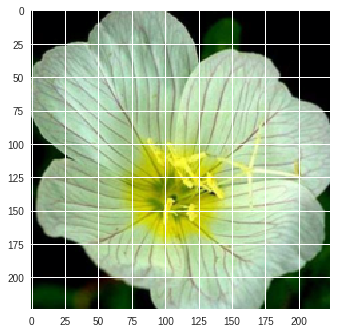

In [18]:

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


imshow(process_image("flower_data/valid/1/image_06739.jpg"))

In [0]:
def check_sanity():
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 1
    path = 'flower_data/valid' + '/1/image_06739.jpg'

    probabilities = predict(path, model)
    image = process_image(path)
    probabilities = probabilities
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

In [0]:
model.class_to_idx =train_data.class_to_idx

ctx = model.class_to_idx


def predict(image_path, model, topk=5):   
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

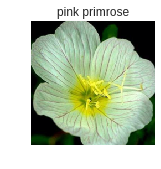

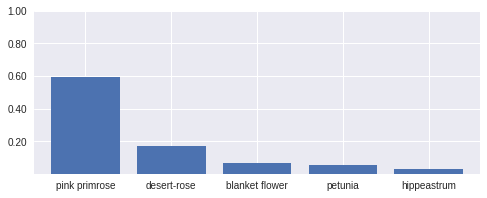

In [23]:

check_sanity()